# Image Classification with Convolutional Neural Networks
We will classify images in this assignment. Convolutional neural networks are very successful with images. A convolutional neural network contains at least one convolutional layer and commonly pooling and dense layers.

Convolutional layers perform a series of convolution operations. A convolution operation consists of elementwise multiplication of a convolutional filter and a slice of input (part of image) that has the same size as the convolutional filter. Output of the convolution operation is the sum of the elementwise products.

For a given input

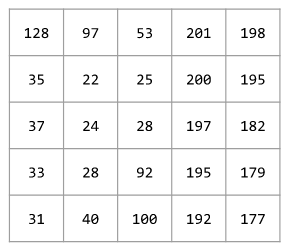

and a convolutional filter

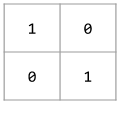

the output of one convolutional operation is calculated as

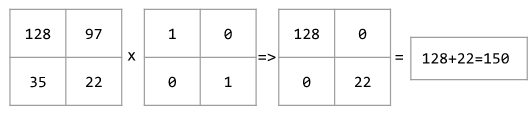

The weights in the convolutional filters are learned in convolutional neural networks in addition to the weights in the possibly existing dense layers.

In [3]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

plt.style.use("ggplot")

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an image recognition dataset with images from 10 classes of vehicles and animals. It is available as a dataset in Tensorflow. We load the dataset and normalize the pixel values to \[0, 1\].

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

We get the shape of the images which we will need later in the code.

In [7]:
image_shape = train_images.shape[1:]
image_shape

(32, 32, 3)

We can plot the first 10 images.

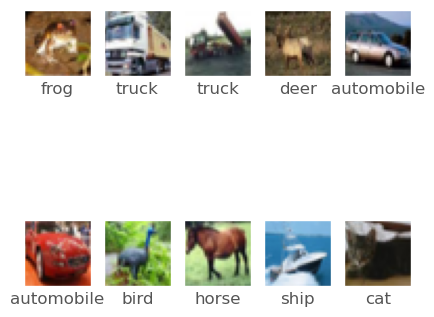

In [8]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(5, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Building the Classifier

We will use the Sequential API of Keras models. Keras provides higher level layers and functions to build neural networks, it acts an interface to TensorFlow. Our model will have 3 convolutional stacks of Conv2D and MaxPooling2D layers. These stacks are very commonly used in convolutional neural networks. Conv2D layers perform convolution operations. MaxPooling2D layers downsample their input by taking the maximum value within a grid whose size is determined by the argument to the layer. In our model, all maxpooling layers downsample a 2$\times$2 grid and all convolutional layer filters are 3$\times$3. We use 32 filters in the first convolutional layer and 64 in the latter ones. We use the ReLU non-linearity in each convolutional layer.

Each image is represented as 3D arrays; one array for each of the red,  blue and green channels. This is reflected in the input_shape to the first Conv2D layer: input size is 32$\times$32$\times$3.

There are two other important parameters of the Conv2D layer. Stride determines how much the filter is shifted in each dimension. A stride > 1 results in smaller outputs of the convolutional layer. The second parameter is padding. Padding='valid' keeps outputs of filters that are fully in the image (no padding is applied), padding='same' keeps the image size by zero-padding the image.

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=image_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

The last layer will have 10 nodes: one for each of the classes in the dataset. Adding one or more dense layer(s) before the last layer allows the model to learn complex representations of the images. Between the convolutional stacks and the dense layers, there needs to be a layer for flattening since the output of the last convolutional layer is 4$\times$4$\times$64.

In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10))

Summary of the model gives useful information: shapes of output layers and number of parameters in each layer. "None" values in the first dimension of layer output shapes are placeholders for the batch size.

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

Finally, we need to compile and fit our model. There are a number of optimizers available in Keras we will use Adam optimizer. We choose loss as SparseCategoricalCrossentropy which should be selected when the task is classification and the labels are not in one-hot-vector form. For one-hot labels, use CategoricalCrossentropy loss instead. There are two ways to use (Sparse)CategoricalCrossentropy: from_logits=True works with pre-softmax values in which case the output of the last layer in the network is linear, from_logits=False works with softmax outputs directly. Note that using logits is reported to be more numerically stable.

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_images, train_labels, epochs=10, validation_data=(test_images, test_labels)
)

Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5205 - accuracy: 0.4434 - val_loss: 1.2402 - val_accuracy: 0.5520
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1644 - accuracy: 0.5865 - val_loss: 1.0983 - val_accuracy: 0.6102
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0214 - accuracy: 0.6422 - val_loss: 0.9813 - val_accuracy: 0.6573
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9198 - accuracy: 0.6782 - val_loss: 0.9284 - val_accuracy: 0.6850
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8426 - accuracy: 0.7041 - val_loss: 0.9013 - val_accuracy: 0.6888
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7795 - accuracy: 0.7275 - val_loss: 0.9131 - val_accuracy: 0.6920
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7316 - accuracy: 0.7443 - val_loss: 0.8763 - val_ac

History object returned by fit contains the training and validation accuracies. From the plot, we can see that our model overfit to the training data. This is also evident from the test accuracy.

We can evaluate the model on the test set with `model.evaluate` to understand the generalization performance of our model.

313/313 - 1s - loss: 0.8844 - accuracy: 0.7056 - 1s/epoch - 3ms/step


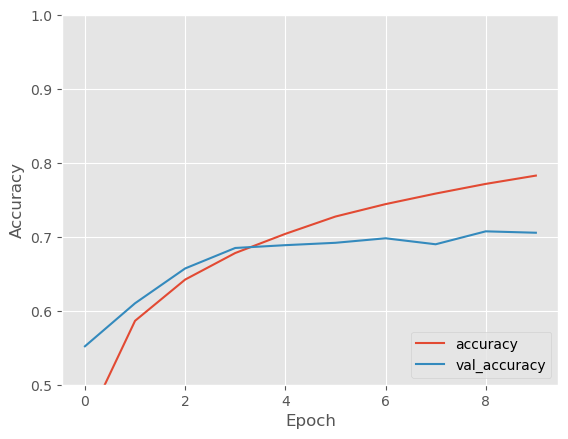

In [17]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

## Confusion Matrix
Confusion matrices visualize performance of classification algorithms in a table layout. Scikit-learn has an implementation of confusion matrix for multiclass data. Each class prediction is treated as one-vs-rest.

Our CNN model is set up to output logits, hence the `predict` method also returns logits. We will use the `softmax` function to get class probabilities for each test image, then use the class for which the probability was highest.

In [18]:
logits = model.predict(test_images)
preds = tf.math.argmax(tf.nn.softmax(logits), axis=1)

313/313 [==============================] - 1s 3ms/step


For a two class classification problem would look like 

|Predicted/True| 0 | 1   |
|-------------|------|------|
|0             |True negative|False positive|
|1        |False negative|True positive|

For the ten classes in CIFAR10 dataset, the main diagonal of the confusion matrix shows the number of correctly predicted examples in each class. In general, for row $i$ and column $j$, entry $c_{ij}$ in the confusion matrix shows the number of class $i$ examples that are predicted as class $j$.


In [19]:
conf_mat = confusion_matrix(test_labels, preds)

To get information about the predictions for images in, for example, the "deer" class, we can extract the fourth row ("deer" is the fourth class") in the confusion matrix.

In [20]:
conf_mat[4]
conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

In [21]:
def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "2.2f"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

/var/folders/gx/zl8f86ps4m5dm0p35jcc72b80000gn/T/ipykernel_11481/2959321020.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


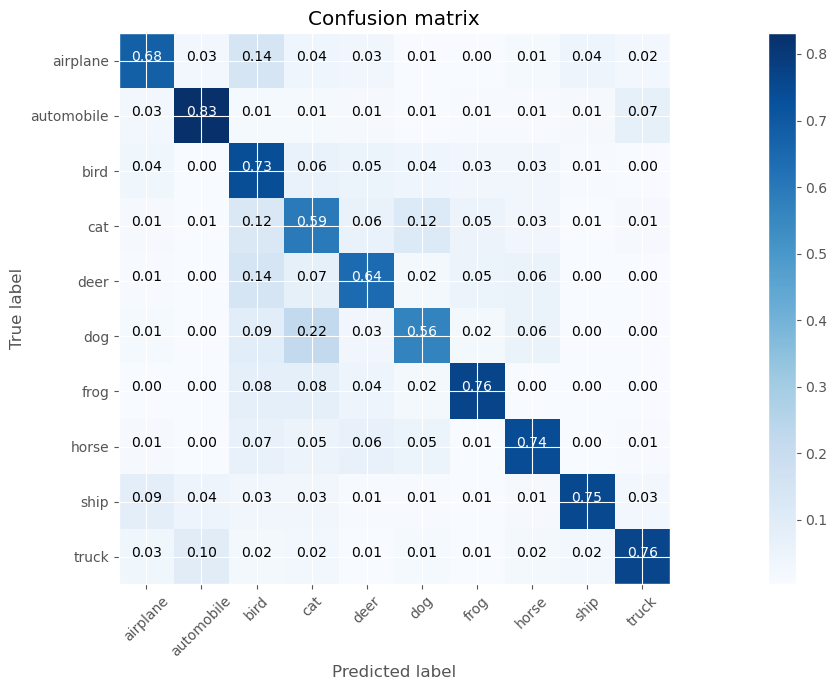

In [22]:
plt.figure(figsize=(20, 7))
plot_confusion_matrix(conf_mat, classes=class_names)

## K-fold cross-validation

Scikit provides implementations of many useful techniques and tools commonly used in machine learning. One such technique is k-fold cross-validation which works with scikit classifiers. We can wrap our tensorflow model to act like a Scikit classifier. tf.keras provides a wrapper "KerasClassifier" to turn a tf.Keras model into a Scikit classifier.

"KerasClassifier" expects a function that builds a Keras model, so we will gather model building code into a function.

In [23]:
def create_model(
    filter_nos=[32, 32, 32],
    filter_size=(3, 3),
    dense_layers=[64],
    input_shape=image_shape,
):
    """
    Args:
        filter_nos (tuple): number of filters in each Conv2D layer
        filter_size (tuple): size of Conv2D filters. Filters are assumed to have uniform sizes across layers.
        input_shape (tuple): shape of the input of the first layer
        dense_layer (tuple): number of hidden units in each Dense layer except the output layer. Output layer is hardcoded to the number of classes.
    """

    model = models.Sequential()

    for i, filter_no in enumerate(filter_nos):
        if i == 0:
            # first Conv2D requires input_shape
            model.add(
                layers.Conv2D(
                    filter_no, filter_size, activation="relu", input_shape=input_shape
                )
            )
        else:
            model.add(layers.Conv2D(filter_no, filter_size, activation="relu"))

        if i + 1 < len(filter_nos):
            model.add(
                layers.MaxPooling2D((2, 2))
            )  # add MaxPooling layer to all but the last convolutional stack

    model.add(layers.Flatten())

    for dense_layer in dense_layers:
        model.add(layers.Dense(dense_layer, activation="relu"))

    model.add(layers.Dense(10))  # output layer

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

For instance, using the create model function, we could reproduce the model we had built before as before.

In [24]:
model = create_model(filter_nos=(32, 64, 64), filter_size=(3, 3), dense_layers=(64,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

We will use the KerasClassifier as the estimator in `cross_val_score`. It accepts the function that builds our Keras model, arguments to that function as well as training parameters `epochs` and `batch_size`.

In [25]:
model = KerasClassifier(
    create_model,
    filter_nos=(32, 64, 64),
    filter_size=(3, 3),
    dense_layers=(64,),
    epochs=10,
    batch_size=32,
)

/var/folders/gx/zl8f86ps4m5dm0p35jcc72b80000gn/T/ipykernel_11481/4016992159.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


We also need to create an object that handles data splitting for k-fold cross-validation. `StratifiedKFold` does this.

In [26]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)
fold_accuracies = cross_val_score(
    estimator=model, X=train_images, y=train_labels, cv=kfold
)

Epoch 1/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5946 - accuracy: 0.4161
Epoch 2/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2459 - accuracy: 0.5543
Epoch 3/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0783 - accuracy: 0.6182
Epoch 4/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9771 - accuracy: 0.6544
Epoch 5/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8989 - accuracy: 0.6847
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8274 - accuracy: 0.7096
Epoch 7/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7817 - accuracy: 0.7256
Epoch 8/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7308 - accuracy: 0.7446
Epoch 9/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6860 - accuracy: 0.7578
Epoch 10/10
313/313 [==============================] - 1s 4ms/step - loss

Finally, we can print the mean accuracy and the 95\% confidence interval.

In [27]:
print(
    "Accuracy: {:.3f} (+/- {:.3f})".format(
        fold_accuracies.mean(), fold_accuracies.std() * 2
    )
)

Accuracy: 0.694 (+/- 0.011)


## Exercise

We had observed that the CNN model had overfit the training data. Implement `EarlyStopping`, `Dropout` and $l_2$  regularization techniques to reduce overfitting. You can use all three together or separately to compare performance. Plot training and validation accuracies with the regularized model(s).


*Hint:* This can be done by adding layers to the model and/or adding Keras callbacks. To add layers to the model, you'll need to redefine the architecture of the model. 

Here are relevant documentation: [$l_2$](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [20]:
dropout_rate = 0.20
reg = tf.keras.regularizers.L2(l2=0.0001)
print(image_shape)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=reg, activation="relu", input_shape=image_shape, padding='same'))
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=reg, activation="relu", input_shape=image_shape, padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=reg, activation="relu", padding='same'))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=reg, activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=reg, activation="relu", padding='same'))
model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=reg, activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
#model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Dense(10))

#model.summary()

(32, 32, 3)


Note: Using early stopping and training for 20 epochs, an accuracy of ~71% was reached. Implementing dropout and L2 regularization in the model allows an accuracy of 76% to be reached. However, greater accuracy did not come without a cost in training speed. In order to reach greater accuracies, twice the number of epochs were needed. After plotting the data it was interesting to see what classes were often confused. The most common mixups were between cats, dogs, and occasionally frogs.

In [21]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    train_images, train_labels, epochs=60, validation_data=(test_images, test_labels), callbacks=[es]
)

Epoch 1/60
1563/1563 [==============================] - 26s 16ms/step - loss: 1.5279 - accuracy: 0.4480 - val_loss: 1.2023 - val_accuracy: 0.5800
Epoch 2/60
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1578 - accuracy: 0.5967 - val_loss: 0.9942 - val_accuracy: 0.6623
Epoch 3/60
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9996 - accuracy: 0.6628 - val_loss: 0.9493 - val_accuracy: 0.6837
Epoch 4/60
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9102 - accuracy: 0.6957 - val_loss: 0.8536 - val_accuracy: 0.7193
Epoch 5/60
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8516 - accuracy: 0.7181 - val_loss: 0.8071 - val_accuracy: 0.7370
Epoch 6/60
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8108 - accuracy: 0.7362 - val_loss: 0.7936 - val_accuracy: 0.7443
Epoch 7/60
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7684 - accuracy: 0.7526 - val_loss: 0.8000 -

313/313 - 2s - loss: 0.8491 - accuracy: 0.7514 - 2s/epoch - 5ms/step


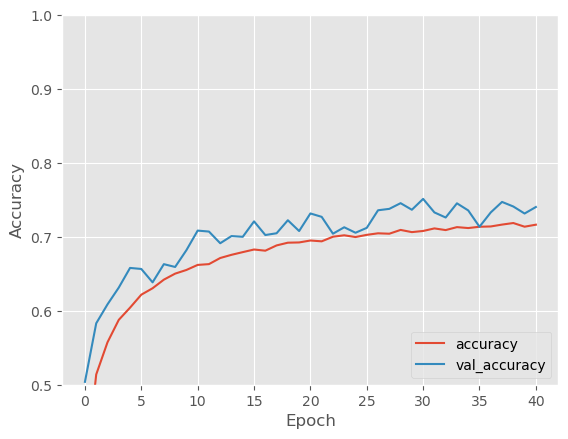

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [ ]:
logits = model.predict(test_images)
preds = tf.math.argmax(tf.nn.softmax(logits), axis=1)
conf_mat = confusion_matrix(test_labels, preds)
conf_mat[4]
conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

313/313 [==============================] - 2s 5ms/step


In [ ]:
def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "2.2f"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

/var/folders/gx/zl8f86ps4m5dm0p35jcc72b80000gn/T/ipykernel_19357/2959321020.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


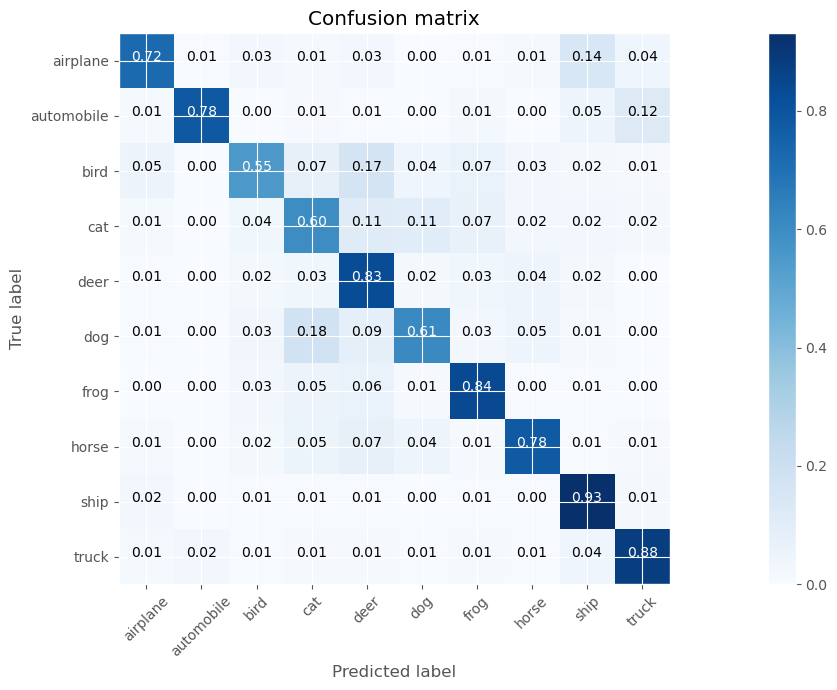

In [ ]:
plt.figure(figsize=(20, 7))
plot_confusion_matrix(conf_mat, classes=class_names)

Content in this notebook is borrowed and adapted from [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn) which is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Zeynep Hakguder (<a href="mailto:zphakguder@gmail.com">zphakguder@gmail.com</a>) for further questions or inquries.